# Solving Relativistic Fluid 2D

### Introduction
The goal of this notebook is to study turbulence from a perfect relativistic fluid. We consider the stress energy tensor for a perfect fluid in Minkowski space,

\begin{equation}
T_{ab} = p\eta_{ab} + (e+p)u_a u_b
\end{equation}

The equations of motion for such fluid are,

\begin{equation}
\label{EOM}
\partial_a T^{ab} = 0. \quad (1)
\end{equation}

Here we focus on a conformal fluid, that is the stress energy tensor is traceless,

$$T_a^a = 0 \to e = -2p.$$

To solve eq.1 numerically, we rewrite the EOM in conservative variables $U=(D,S^i)$ where,

$$\frac{D}{2} = T^{00} = \frac{e}{2}\left(-1+\frac{3}{W^2}\right)$$

$$\frac{S^i}{2} = T^{0i} = \frac{3e}{2}\frac{v^i}{W^2}$$

Where we have the Lorentz factor $W = \sqrt{1-v^iv_i}$. Now the EOM in conservative form,

$$\partial_t D + \partial_i S^i = 0$$
$$\partial_t S^i + \partial_j(e \delta^{ij} + S^i v^j) = 0$$

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  

## Parameters

In [2]:
# Number of grid points
Nx = 801
Ny = 801
Nt = 15

# Discretisation parameters
cfl = 1
dx  = 10./(Nx)
dy  = 10./(Ny)
dt  = cfl*min(dx,dy)

# Spacial linspace
x = np.linspace(0,dx*Nx,Nx)
y = np.linspace(0,dy*Ny,Ny)

# physical parameters
gamma = 1.5

# Numerical parameters (floor)
epsilon = 10e-5

In [3]:
# Variables to store solutions
v_x_old = np.zeros((Nx,Ny))
v_x_new = np.zeros((Nx,Ny))

v_y_old = np.zeros((Nx,Ny))
v_y_new = np.zeros((Nx,Ny))

rho_old = np.ones((Nx,Ny))
rho_new = np.ones((Nx,Ny))

D_old = np.zeros((Nx,Ny))
D_new = np.zeros((Nx,Ny))

s_x_old = np.zeros((Nx,Ny))
s_x_new = np.zeros((Nx,Ny))

s_y_old = np.zeros((Nx,Ny))
s_y_new = np.zeros((Nx,Ny))

## Variable conversion (C->P)

To switch from conservative to primitive variable we first note that,

$$S_iS^i/D^2 = 9(1-W^2)(3-W^2)^2$$

Now let $\Theta = S_iS^i/D^2$ and solving for $W^2$ we get,

$$W^2 = \frac{3}{2\Theta} \left(2 \Theta - 3 + \sqrt{9-8\Theta}\right)$$

With this,

$$e = \frac{D}{-1+3W^{-2}}$$

$$v^i = \frac{W^2 S^i}{3e}$$

In [4]:
def CtoP(D,Sx,Sy):
    
    Nx = S_x_old.shape[0]
    Nx = S_x_old.shape[1]
    prho = np.zeros((Nx,Ny))
    v_x  = np.zeros((Nx,Ny))
    v_y  = np.zeros((Nx,Ny))
    
    # Compute theta
    theta = (np.multiply(Sx,Sx)+np.multiply(Sy,Sy))/np.multiply(D,D)
    
    # Compute W^2
    W2 = (1.5/theta)*(2*theta-3.0+np.sqrt(9.0-8.0*theta))
    
    # Compute primitives
    rho = D/(-1+3/W2)
    v_x = (np.multiply(W2,Sx))/(3*rho)
    v_y = (np.multiply(W2,Sy))/(3*rho)
    
    return prho, v_x, v_y

def PtoC(rho,v_x,v_y,Nx,Ny):
    
    D = np.zeros((Nx,Ny))
    S_x = np.zeros((Nx,Ny))
    S_y = np.zeros((Nx,Ny))
    
    # Compute W^2
    W2 = np.ones((Nx,Ny))-(np.multiply(v_x,v_x)+np.multiply(v_y,v_y))
    
    D   = np.multiply(rho,-np.ones((Nx,Ny)) + 3.0/W2)
    S_x = 3.0*v_x/W2
    S_y = 3.0*v_y/W2
    
    return D, S_x, S_y

## Initial Data

In [5]:
def gen_init(dx,dy,Nx,Ny,x,y,plot=False):
    # initial data assumes square grid
    v_x = np.zeros((Nx,Ny))
    v_y = np.zeros((Nx,Ny))
    
    S_x = np.zeros((Nx,Ny))
    S_y = np.zeros((Nx,Ny))
    
    D = np.zeros((Nx,Ny))
    
    # Density of 1 everywhere
    rho = np.ones((Nx,Ny))
    
    W = np.zeros((Nx,Ny))
    W2 = np.zeros((Nx,Ny))
    
    # Generate velocities
    for i in range(Nx):
        if(y[i]>3 and y[i]<7):
            v_x[:,i] = 0.5*np.sin((20*np.pi)/(y[-1]*y[i]))*(y[i]-3.0)**2*((y[i]-7.0)**2)/16
        else:
            # Set to floor
            v_x[:,i] = epsilon
        if(x[i]>3 and x[i] < 7):
            v_y[:,i] = 0.5*np.sin((20*np.pi)/(x[-1]*x[i]))*(x[i]-3.0)**2*((x[i]-7.0)**2)/16
        else:
            # Set to floor
            v_y[:,i] = epsilon

    # Compute conservative variables
    D, S_x, S_y = PtoC(rho,v_x,v_y,Nx,Ny)

    if plot:
        fig = plt.figure(figsize=(15,15))
        ax = fig.add_subplot(111, projection='3d')
        X, Y = np.meshgrid(x, y)
        
        ax.plot_surface(X, Y, S_x)
        
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('S_x Label')
        
        plt.show()
    
    return v_x, v_y, rho, D, S_x, S_y

In [6]:
# Generate initial data
v_x_old, v_y_old, rho_old, D_old, S_x_old, S_y_old = gen_init(dx,dy,Nx,Ny,x,y)

### Define finite difference fn

In [7]:
# 2nd order Central difference for 1st degree derivative 
def dudx(u,dx):
    
    du = np.zeros((len(u),len(u)))
    
    # Assume periodic BC
    du[0]  = 0.5*(u[2]-u[-1])/dx
    du[-1] = 0.5*(u[2]-u[-1])/dx
    
    for i in range(1,len(u)-1):
        du[i] = 0.5*(u[i+1]-u[i-1])/dx
        
    return du

### Define fluxes

In [8]:
def fluxes(rho,v_x,v_y,D,S_x,S_y):
    
    Fx_rho = S_x
    Fy_rho = S_y
    
    Fx_Sx = rho+np.multiply(S_x,v_x)
    Fy_Sx = np.multiply(S_x,v_y)
    
    Fx_Sy = np.multiply(S_y,v_x)
    Fy_Sy = rho+np.multiply(S_y,v_y)
    
    return Fx_rho, Fy_rho, Fx_Sx, Fy_Sx, Fx_Sy, Fy_Sy

def RHS(t, Z):
    
    D   = Z[0]
    S_x = Z[1]
    S_y = Z[2]
    
    rho, v_x, v_y =  CtoP(D,S_x,S_y)
    
    # Compute fluxes
    Fx_rho, Fy_rho, Fx_Sx, Fy_Sx, Fx_Sy, Fy_Sy = fluxes(rho,v_x,v_y,D,S_x,S_y)
        
    # Compute derivatives
    dFx_rho = dudx(Fx_rho[:,0],dx)
    dFy_rho = dudx(Fy_rho[0,:],dx)
    
    dFx_Sx  = dudx(Fx_Sx[:,0],dx)
    dFy_Sx  = dudx(Fy_Sx[0,:],dx)
    
    dFx_Sy  = dudx(Fx_Sy[:,0],dx)
    dFy_Sy  = dudx(Fy_Sy[0,:],dx)
    
    dD   = -dFx_rho-dFy_rho
    dS_x = -dFx_Sx-dFy_Sx
    dS_y = -dFx_Sy-dFy_Sy
        
    return np.array([dD, dS_x, dS_y])

### Define RK4

In [9]:
def rk4_step(f, x, y, h):
    
    k1 = h*f(0, y)
    k2 = h*f(0, y + 0.5 * k1)
    k3 = h*f(0, y + 0.5 * k2)
    k4 = h*f(0, y + k3)
    
    return y + (k1 + k2 + k2 + k3 + k3 + k4) / 6

### Evolve

In [10]:
# Create Z vector
Z_old = np.array([D_old,S_x_old,S_y_old])
t = [0]

for i in range(1,Nt+1):
    print(i)
    Z_new = rk4_step(RHS,t,Z_old,dt)
    t.append(t[0]+i*dt)
    Z_old = Z_new

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


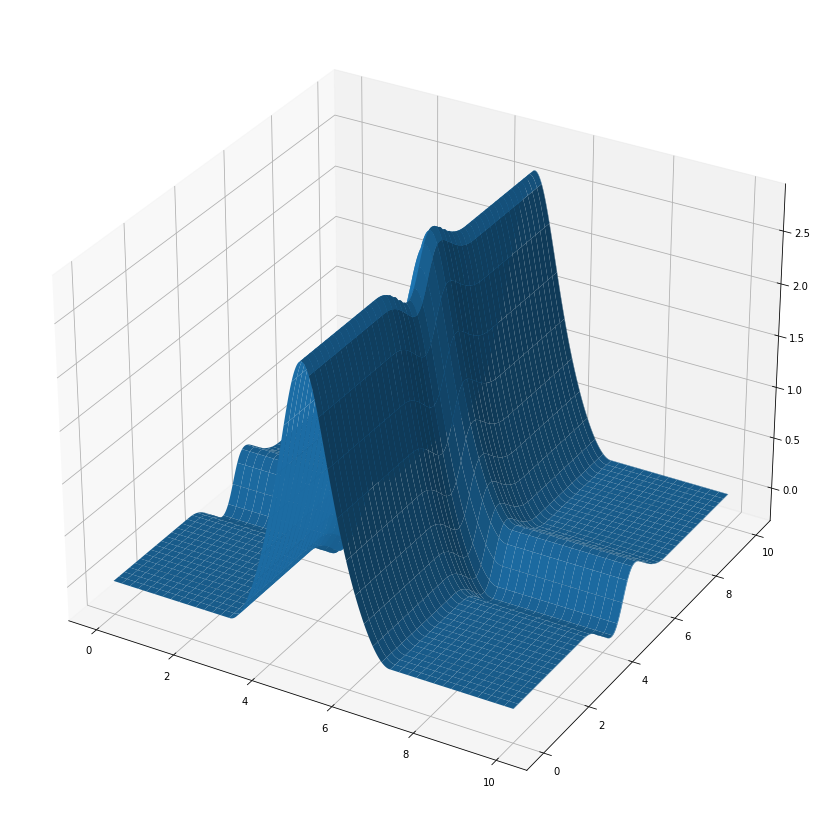

In [11]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(x, y)
        
ax.plot_surface(X, Y, Z_new[1])
#ax.plot_surface(X, Y, S_x_old)
        
plt.show()

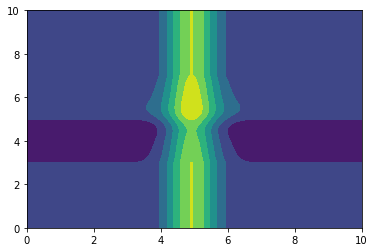

In [12]:
plt.contourf(X, Y, Z_new[0])